In [1]:
# do augmentation - shuting
import os
from PIL import Image
import torchvision.transforms as transforms
import random
import torch

random.seed(42)
torch.manual_seed(42)

augmentation = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
    ], p=0.5),

    transforms.RandomApply([
        transforms.RandomRotation(degrees=30),
    ], p=0.8),

    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1),  
            scale=(0.95, 1.05),    
            shear=5               
        ),
    ], p=0.7),

    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.3,
            contrast=0.3,
            saturation=0.3,
            hue=0.02
        ),
    ], p=0.8),

    transforms.RandomApply([
        transforms.RandomGrayscale(p=1.0),
    ], p=0.05), #0.2->0.05

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3),
    ], p=0.3),

    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.ToPILImage()
])

# script_dir = os.path.dirname(os.path.abspath(__file__))
input_root = "../train"
output_root = "augmented_train_2"
aug_per_image = 5

if not os.path.exists(input_root):
    raise FileNotFoundError(f"input root not exist: {os.path.abspath(input_root)}")


for class_name in os.listdir(input_root):
    input_class_path = os.path.join(input_root, class_name)
    output_class_path = os.path.join(output_root, class_name)

    if not os.path.isdir(input_class_path):
        continue

    os.makedirs(output_class_path, exist_ok=True)

    for img_name in os.listdir(input_class_path):
        img_path = os.path.join(input_class_path, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"skip damage image: {img_path}")
            continue

        for i in range(aug_per_image):
            aug_img = augmentation(image)
            save_path = os.path.join(
                output_class_path,
                f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
            )
            aug_img.save(save_path)

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, LR: 0.010000, Train Loss: 184.5755, Train Acc: 0.2625, Val Loss: 13.9957, Val Acc: 0.3438
Epoch 2, LR: 0.010000, Train Loss: 52.6527, Train Acc: 0.3906, Val Loss: 12.0856, Val Acc: 0.3750
Epoch 3, LR: 0.010000, Train Loss: 51.6565, Train Acc: 0.3766, Val Loss: 10.7514, Val Acc: 0.4938
Epoch 4, LR: 0.010000, Train Loss: 64.1554, Train Acc: 0.3719, Val Loss: 14.5884, Val Acc: 0.2938
Epoch 5, LR: 0.010000, Train Loss: 61.5243, Train Acc: 0.4281, Val Loss: 13.7011, Val Acc: 0.4000
Epoch 6, LR: 0.010000, Train Loss: 61.9957, Train Acc: 0.3734, Val Loss: 19.9953, Val Acc: 0.2625
Epoch 7, LR: 0.005000, Train Loss: 65.8008, Train Acc: 0.4031, Val Loss: 11.5856, Val Acc: 0.4250
Epoch 8, LR: 0.005000, Train Loss: 46.7140, Train Acc: 0.4797, Val Loss: 10.5012, Val Acc: 0.5563
Epoch 9, LR: 0.005000, Train Loss: 43.1095, Train Acc: 0.5031, Val Loss: 9.9500, Val Acc: 0.5500
Epoch 10, LR: 0.005000, Train Loss: 41.0550, Train A

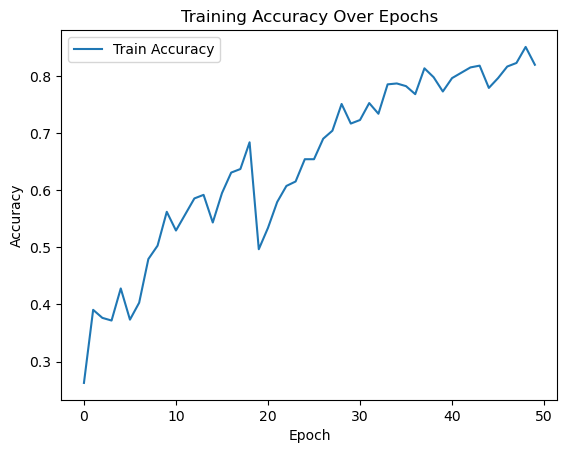

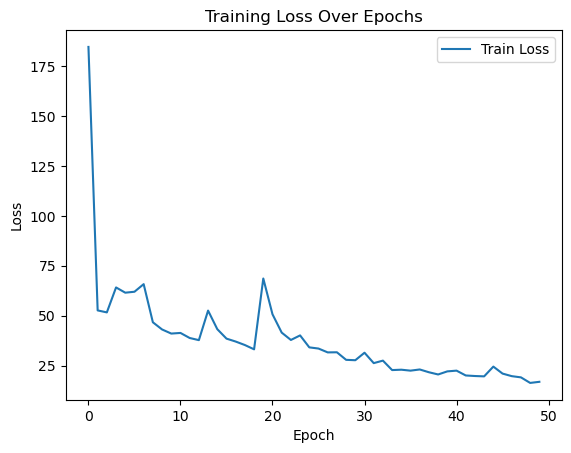

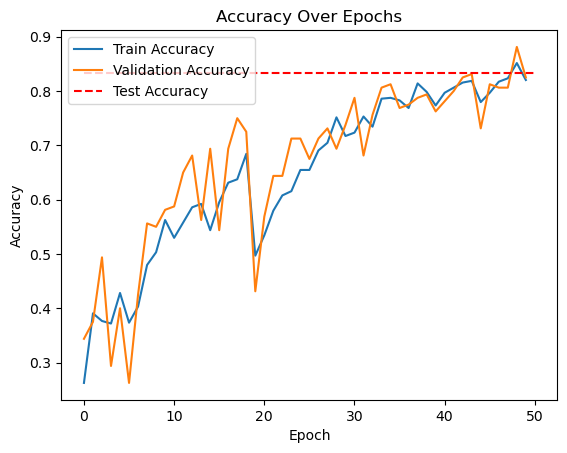

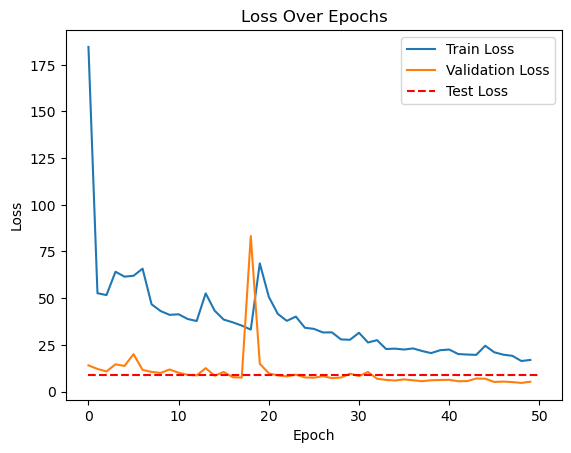

In [2]:
# Import required libraries for data handling, model building, and visualization
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split


# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 80% and validation by 20%--Lewis
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data--Ben
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.LeakyReLU(negative_slope=0.01),                                 #LeakyReLU activation-shiying
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.LeakyReLU(negative_slope=0.01), 
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1), # Third convolutional layer
            nn.LeakyReLU(negative_slope=0.01), 
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(64 * 12 * 12, 256),                # Fully connected layer
            nn.LeakyReLU(negative_slope=0.01), 
            nn.Dropout(0.3),                              # Dropout for regularization-shiying
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
#optimizer/learning rate/learning rate scheduler-Pris&Dionis
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3, min_lr=1e-6)



#class for Early Stopping--Dionis
class EarlyStopping:
    #patience is the num of epochs to wait without any changes in val loss before stopping run
    #delta is the delta change/minimum change in val loss to be considered as an improvement
    def __init__(self, patience, delta):
        #declaring variables
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

        #pass in the current epoch's val_loss for evaluation
    def __call__ (self, val_loss):

        #for first run, will take the initial val_loss as the best_loss first
        if self.best_loss is None:
            self.best_loss = val_loss
        #if the current val_loss is better or more than the best val so far, increment self counter for tracking
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True #if self counter == 5 (5 epoch runs with no improvement) then to set boolean flag to True
        else:
            self.best_loss = val_loss
            self.counter = 0

#instantiating earlystopping class
early_stopping = EarlyStopping(patience=8, delta=0.0001)

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 50

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)

    scheduler.step(val_running_loss)
    early_stopping(val_running_loss)

    #if early_stopping.early_stop == True, to print
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break


    current_lr = optimizer.param_groups[0]['lr']
    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, LR: {current_lr:.6f}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
      f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Final evaluation on test set (after training)
model.eval()
y_true = []
y_pred = []
test_correct = 0
test_total = 0
test_running_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (preds == labels).sum().item()
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

test_acc = test_correct / test_total
test_loss = test_running_loss
print(f"\nFinal Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.hlines(test_acc, 0, len(train_acc), colors='r', linestyles='dashed', label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.hlines(test_loss, 0, len(train_loss), colors='r', linestyles='dashed', label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()